## __0. Bibliotecas__

In [174]:
# mover os imports para cá

## __1. Datasets__

In [175]:
# carregar todos os datasets aqui

## __2. Pré-processamento dos dados__

Uma vez que vamos trabalhar apenas com pontos no plano cartesiano, precisamos transformar nossos dados em uma **matriz bidimensional**. Para isso, utilizaremos a técnica **SVD** (Singular Value Decomposition) que reduz uma matriz *n*-dimensional em uma matriz *k*-dimensional, onde *k* é o número de fatores latentes. Para nosso trabalho, *k* é sempre 2.

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
iris = datasets.load_iris() # apenas o iris tem duas classes linearmente separáveis
digits = datasets.load_digits()
wine = datasets.load_wine()
cancer = datasets.load_breast_cancer()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['Target'] = pd.DataFrame(iris.target)


In [177]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=4, random_state=42)
data_points = svd.fit_transform(df)

In [178]:
df_new = pd.DataFrame(data_points, columns=['x','y'])
df_new['Target'] = pd.DataFrame(iris.target)
df_new

,x,y,Target
0,5.847277,2.461922,0
1,5.511162,2.138145,0
2,5.386715,2.244409,0
3,5.376754,2.035803,0
4,5.810511,2.483696,0
...,...,...,...
145,9.419625,-1.095265,2
146,8.766359,-1.230153,2
147,9.220995,-1.063022,2
148,9.300111,-1.164300,2


## __3. Envoltória Convexa__


#### Implementação do algoritmo de Gift Wrapping(Jarvis March) para determinar as envoltórias das amostras. Este algoritmo possui complexidade $O(nh)$, sendo $n$ o número de pontos e $h$ os pontos que efetivamente estão na envoltória.

In [179]:
# classe para representar pontos bidimensionais no espaço
class Ponto:
    def __init__(self, x, y, rotulo):
        self.x = x
        self.y = y
        self.rotulo = rotulo

In [180]:
#calculando o produto vetorial entre segmentos ab e ac, a = ancora
def produto_vetorial(ancora, b, c):
    return ((b.x-ancora.x)*(c.y-ancora.y) - (c.x-ancora.x)*(b.y-ancora.y))


In [181]:
# encontrando o ponto mais embaixo em relação a y
def mais_a_esquerda(pontos):
    min = 0
    for i in range(1,len(pontos)):
        if pontos[i].y < pontos[min].y:
            min = i
        elif pontos[i].y == pontos[min].y:
            if pontos[i].x < pontos[min].x: # em caso de empate, escolhemos o ponto mais a esquerda
                min = i
    return min

In [182]:
# funcao que recebe um vetor de pontos, e retorna lista com pontos da envoltoria convexa
def gift_wrapping(pontos):
    i_esquerda = mais_a_esquerda(pontos) # guarda indice do ponto mais a esquerda
    p = pontos[i_esquerda]

    prox = (i_esquerda + 1) % len(pontos)

    teste = 0

    envoltoria = [] #incializa envoltoria vazia
    envoltoria.append(p) # adiciona ponto mais à esquerda a envoltoria

    q = p
    while(True):
        # calcula o prox ponto da envoltoria
        while(teste != len(pontos)):
            det = produto_vetorial(q, pontos[prox], pontos[teste])
            if det < 0: # se for negativo, pontos[teste] tem o menor angulo polar,sendo o prox ponto da envoltoria
                prox = teste
            # atualiza teste
            teste = teste+1;

        # se tivermos retornados a ancora, loop acaba
        if p == pontos[prox]:
            break

        # adiciona ponto a envoltoria
        envoltoria.append(pontos[prox])

        # atualiza variáveis
        q = pontos[prox]
        prox = (prox + 1) % len(pontos)
        teste = 0

    return envoltoria

In [183]:
#pontos = [Ponto(x, y) for x, y in data_points]
pontos = [Ponto(x, y, r) for x, y, r in df_new.values]
envoltoria = gift_wrapping(pontos)

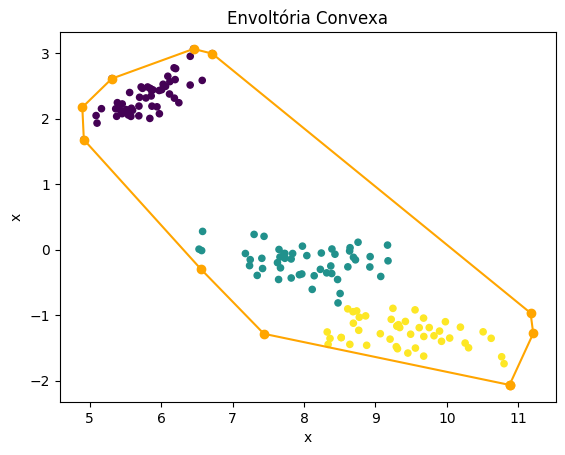

In [184]:
# Criando listas separadas para nomes e idades
Xs1 = [ponto.x for ponto in pontos]
Ys1 = [ponto.y for ponto in pontos]

Xs2 = [ponto.x for ponto in envoltoria]
Ys2 = [ponto.y for ponto in envoltoria]

# Adicionando o primeiro ponto da envoltória ao final para fechar a forma
Xs2.append(envoltoria[0].x)
Ys2.append(envoltoria[0].y)

# Plotando um gráfico de barras
plt.scatter(Xs1, Ys1, c=iris.target, s=20)
plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')
plt.xlabel('x')
plt.ylabel('x')
plt.title('Envoltória Convexa')
plt.show()

<Figure size 640x480 with 0 Axes>

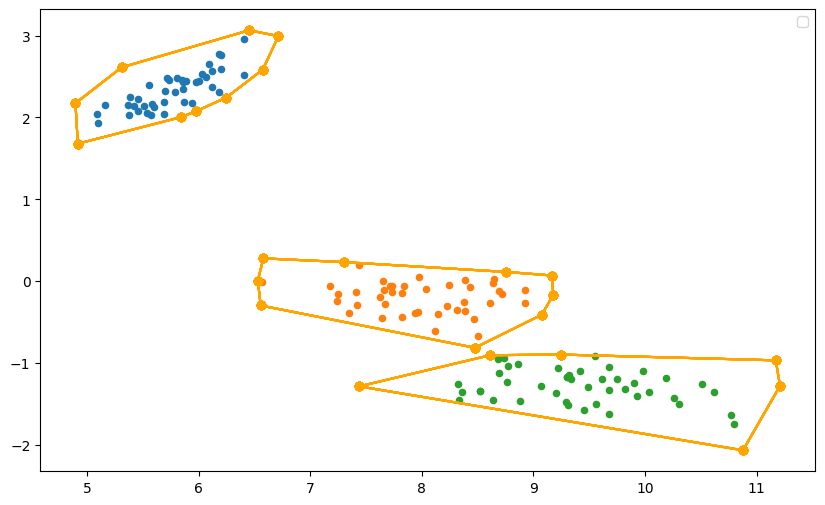

In [185]:
# testando envoltoria com a matriz bidimensional
plt.clf()
plt.figure(figsize = (10, 6))
names = iris.target_names
label = (iris.target).astype(int)
colors = ['b','r','g']
for i in range(len(names)):
    bucket = df_new[df_new['Target'] == i]
    bucket = bucket.iloc[:,[0,1,2]].values
    bucket_points = [Ponto(x, y, r) for x, y, r in bucket]
    envoltoria[i] = gift_wrapping(bucket_points)
    Xs1 = [ponto.x for ponto in bucket_points]
    Ys1 = [ponto.y for ponto in bucket_points]
    plt.scatter(Xs1, Ys1, s=20)
    Xs2 = [ponto.x for ponto in envoltoria[i]]
    Ys2 = [ponto.y for ponto in envoltoria[i]]
    Xs2.append(envoltoria[i][0].x)
    Ys2.append(envoltoria[i][0].y)
    for j in envoltoria:
        plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')
plt.legend()
plt.show()

In [186]:
'''#testando envoltoria com matriz inteira
plt.clf()
plt.figure(figsize = (10, 6))
names = iris.target_names
label = (iris.target).astype(int)
colors = ['b','r','g']
plt.title('Petal Width vs Petal Length')
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
for i in range(len(names)):
    bucket = df[df['Target'] == i]
    bucket = bucket.iloc[:,[2,3,4]].values
    bucket_points = [Ponto(x, y, r) for x, y, r in bucket]
    envoltoria[i] = gift_wrapping(bucket_points)
    Xs1 = [ponto.x for ponto in bucket_points]
    Ys1 = [ponto.y for ponto in bucket_points]
    plt.scatter(Xs1, Ys1, s=20)
    Xs2 = [ponto.x for ponto in envoltoria[i]]
    Ys2 = [ponto.y for ponto in envoltoria[i]]
    Xs2.append(envoltoria[i][0].x)
    Ys2.append(envoltoria[i][0].y)
    for j in envoltoria:
        plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')
plt.legend()
plt.show()'''

"#testando envoltoria com matriz inteira\nplt.clf()\nplt.figure(figsize = (10, 6))\nnames = iris.target_names\nlabel = (iris.target).astype(int)\ncolors = ['b','r','g']\nplt.title('Petal Width vs Petal Length')\nplt.xlabel(iris.feature_names[2])\nplt.ylabel(iris.feature_names[3])\nfor i in range(len(names)):\n    bucket = df[df['Target'] == i]\n    bucket = bucket.iloc[:,[2,3,4]].values\n    bucket_points = [Ponto(x, y, r) for x, y, r in bucket]\n    envoltoria[i] = gift_wrapping(bucket_points)\n    Xs1 = [ponto.x for ponto in bucket_points]\n    Ys1 = [ponto.y for ponto in bucket_points]\n    plt.scatter(Xs1, Ys1, s=20)\n    Xs2 = [ponto.x for ponto in envoltoria[i]]\n    Ys2 = [ponto.y for ponto in envoltoria[i]]\n    Xs2.append(envoltoria[i][0].x)\n    Ys2.append(envoltoria[i][0].y)\n    for j in envoltoria:\n        plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')\nplt.legend()\nplt.show()"

## __4. Varredura Linear__


#### Implementação da varredura linear para verificação de intercessão de segmentos das envoltórias.


In [187]:
def on_segment(p1, p2, p):
    return min(p1.x, p2.x) <= p.x <= max(p1.x, p2.x) and min(p1.y, p2.y) <= p.y <= max(p1.y, p2.y)

In [188]:
def intersect(p1, p2, p3, p4):
    d1 = produto_vetorial(p3, p4, p1)
    d2 = produto_vetorial(p3, p4, p2)
    d3 = produto_vetorial(p1, p2, p3)
    d4 = produto_vetorial(p1, p2, p4)

    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and \
        ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True

    elif d1 == 0 and on_segment(p3, p4, p1):
        return True
    elif d2 == 0 and on_segment(p3, p4, p2):
        return True
    elif d3 == 0 and on_segment(p1, p2, p3):
        return True
    elif d4 == 0 and on_segment(p1, p2, p4):
        return True
    else:
        return False

In [189]:
def any_segment_intersect(envoltoria_1, envoltoria_2):
    n = len(envoltoria_1)
    m = len(envoltoria_2)
    for i in range(n):
        for j in range(m):
            if intersect(envoltoria_1[i], envoltoria_1[(i + 1) % n], envoltoria_2[j], envoltoria_2[(j + 1) % m]):
                return True

    return False

In [190]:
res1 = any_segment_intersect(envoltoria[0], envoltoria[1]) # deve retornar False
res2 = any_segment_intersect(envoltoria[1], envoltoria[2]) # deve retornar True
res3 = any_segment_intersect(envoltoria[0], envoltoria[2]) # deve retornar False

In [191]:
print(res1)
print(res2)
print(res3)

False
False
False


## __5. Algoritmo de varredura para achar pontos mais próximos entre dois conjuntos__


##### __5.1) Implementando a classe PontoRotulado:__


In [192]:
#classe ponto rotulado, contém um Ponto e um rótulo(0 ou 1) (necessária para rodar o closest pair)
class PontoRotulado:
    def __init__(self, x, y, rotulo):
        self.ponto = Ponto(x, y)
        self.rotulo = rotulo

#### __5.2) Algoritmo de varredura__
Este algoritmo tem em seu melhor caso complexiadade $O(n.log(n))$. Em seu pior caso, essa complexidade aumenta para $O(n^2)$. Dada a restrição de que cada ponto do par de pontos retornados precisa ser de um conjunto de pontos diferentes, o parâmetro de distância mínima, usado no algoritmo, tende a ter valores maiores do que se executássemos o algoritmo sem essa restrição. Portanto, espera-se que a complexidade executada esteja entre o caso médio e o pior caso do algoritmo.

In [193]:
import sys
import math

# função que retorna par de pontos rotulados mais próximo entre dois conjuntos de pontos rotulados
def par_mais_proximo(pontos):
    # inicializando variáveis
    p1 = (0,0,0)
    p2 = p1

    # ordena a lista de objetos com base nas coordenadas x dos pontos
    ordenados_X = sorted(pontos, key=lambda obj: obj.x)

    # menor distancia inicializada com valor alto
    min = sys.maxsize

    # criando objeto do tipo conjunto
    st = set()
    # adiciona ponto mais a esquerda ao conjunto
    st.add(ordenados_X[0])

    # varredura sobre pontos ordenados em X
    for i in range(1, len(ordenados_X)):
        # cria conjunto de pontos a esquerda do ponto atual numa distancia no máximo d
        l = set([p for p in st if (p.x >= ordenados_X[i].x - min) and (p.y >= ordenados_X[i].y - min) ])
        # conjunto de pontos a direita do ponto atual a uma distancia no máximo d
        r = set([p for p in st if (p.x <= ordenados_X[i].x + min) and (p.y <= ordenados_X[i].y + min)])
        # intercessao de pontos que podem ter distancia menor que d entre si
        intersection = l & r

        # se não houver pontos com distancias possivelmente menores, passa para o proximo ponto ordenado
        if len(intersection) == 0:
            continue

        # loop sobre a interseção dos conjuntos l e r
        for val in intersection:
            if ordenados_X[i].rotulo == val.rotulo:
                continue

            # Calcula a distância entre os pontos
            dist = math.sqrt(math.pow(ordenados_X[i].x - val.x, 2) + math.pow(ordenados_X[i].y - val.y, 2))

            # Atualiza a distância mínima, se necessário
            if min > dist:
                min = dist
                # guardando o par de pontos mais prox até o momento
                p1 = ordenados_X[i]
                p2 = val

        st.add(ordenados_X[i])

    return p1, p2


## __6. Equação da reta classificadora__


##### Para qualquer equação linear $y = mx + b$, as perpendiculares à ela terão todas uma inclinação de $-1/m$, o recíproco oposto da inclinação original. Para encontrar uma reta perpendicular de um dado segmento $p1p2$, sendo que esta reta também passa por um ponto específico $(x, y)$, nesse caso, a mediana do segmento, basta resolver a equação $y = (-1/m)x + b$, substituindo os valores conhecidos de $m$, $x$ e $y$ para resolver $b$.

In [194]:
# retorna  m e b da equação da reta perpendicular
def reta_perpendicular(p1, p2):
    inclinacao_original = (p1.y-p2.y)/(p1.x-p2.x)

    inclinacao_perpendicular = (-1.0)/inclinacao_original
    # calcula a mediana
    mediana = ((p1.x + p2.x)/2, (p1.y + p2.y)/2) # ponto da mediana
    print("mediana %d", mediana)

    b = mediana[1] - inclinacao_perpendicular * mediana[0]
    return (b, inclinacao_perpendicular)

# função para calcular os valores y da reta dada um inclinação m e intercessao b
def reta(m, b, x):
    return m * x + b

# teste dos pontos mais próximos + reta perpendicular


<Figure size 640x480 with 0 Axes>

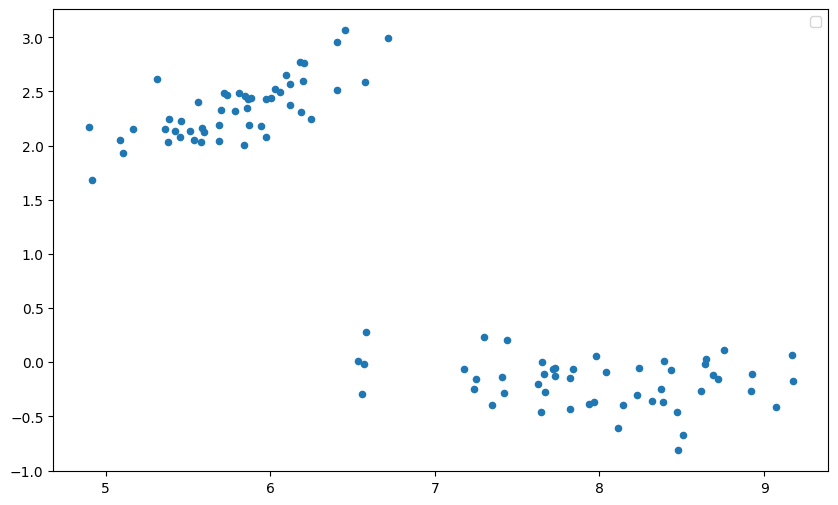

In [195]:
# teste com dois rotulos
plt.clf()
plt.figure(figsize = (10, 6))
names = iris.target_names
label = (iris.target).astype(int)
colors = ['b','r','g']

#for i in range(len(names)-1):

conjuntoA = df_new[df_new['Target'] == 0]
conjuntoB = df_new[df_new['Target'] == 1]
uniao = [conjuntoA, conjuntoB]
bucket = pd.concat(uniao)
bucket = bucket.iloc[:,[0,1,2]].values
bucket_points = [Ponto(x, y, r) for x, y, r in bucket]

Xs1 = [ponto.x for ponto in bucket_points]
Ys1 = [ponto.y for ponto in bucket_points]
plt.scatter(Xs1, Ys1, s=20)
Xs2 = [ponto.x for ponto in envoltoria[i]]
Ys2 = [ponto.y for ponto in envoltoria[i]]
Xs2.append(envoltoria[i][0].x)
Ys2.append(envoltoria[i][0].y)

plt.legend()
plt.show()

In [196]:
p3, p4 = par_mais_proximo(bucket_points)
P3 = Ponto(p3.x, p3.y, p3.rotulo)
P4 = Ponto(p4.x, p4.y, p4.rotulo)

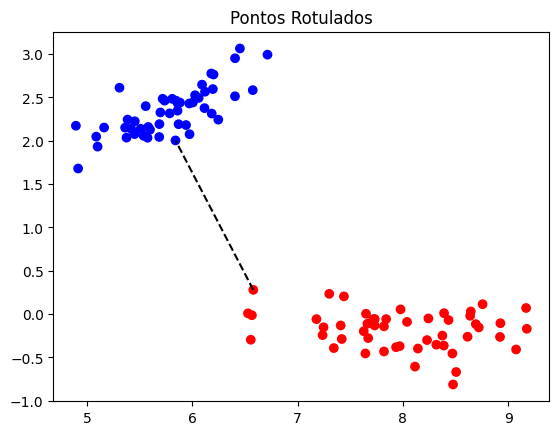

In [197]:
lista_de_objetos = bucket_points
# Cores associadas a cada rótulo
cores = {0: 'blue', 1: 'red'}

# Criando listas de coordenadas e cores
coordenadas_x = [obj.x for obj in lista_de_objetos]
coordenadas_y = [obj.y for obj in lista_de_objetos]
cores_pontos = [cores[obj.rotulo] for obj in lista_de_objetos]

# Plotando os pontos com cores diferentes
plt.scatter(coordenadas_x, coordenadas_y, c=cores_pontos)
# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([P3.x,P4.x], [P3.y,P4.y], 'k--')

# Adicionando legendas e título
plt.title('Pontos Rotulados')

# Exibindo o gráfico
plt.show()


In [198]:
b, m = reta_perpendicular(P3,P4)

mediana %d (6.210804873818397, 1.1414479793199837)


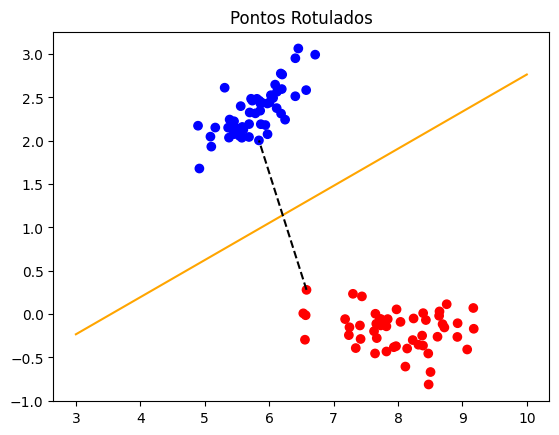

In [199]:
# Gerando valores x para a reta perpendicular
x_valores = np.linspace(3, 10, 50)

# Gerando valores y para a reta perpendicular
y_valores = reta(m, b ,x_valores)

# plotando a reta classificadora
plt.plot(x_valores, y_valores, color='orange')

# Cores associadas a cada rótulo
cores = {0: 'blue', 1: 'red'}

# Criando listas de coordenadas e cores
coordenadas_x = [obj.x for obj in lista_de_objetos]
coordenadas_y = [obj.y for obj in lista_de_objetos]
cores_pontos = [cores[obj.rotulo] for obj in lista_de_objetos]

# Plotando os pontos com cores diferentes
plt.scatter(coordenadas_x, coordenadas_y, c=cores_pontos)
# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([P3.x,P4.x], [P3.y,P4.y], 'k--')

# Adicionando legendas e título
plt.title('Pontos Rotulados')

# Exibindo o gráfico
plt.show()

mediana %d (6.210804873818397, 1.1414479793199837)


<Figure size 640x480 with 0 Axes>

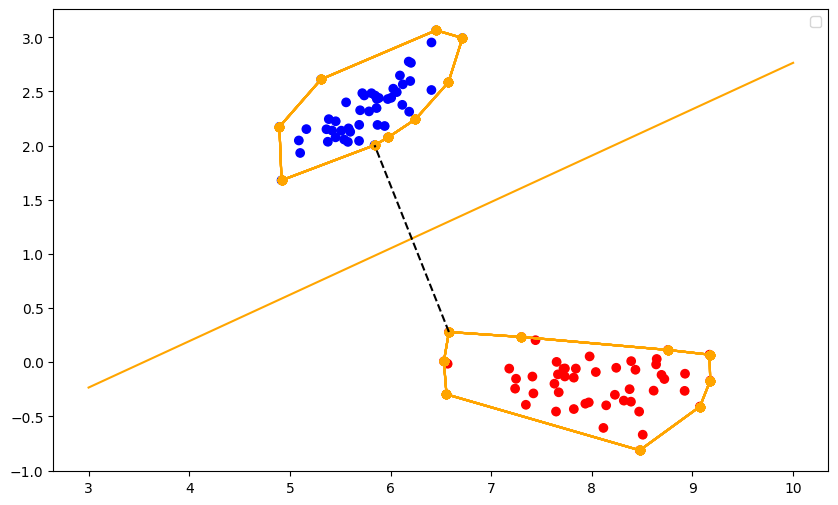

In [201]:
# teste com dois rotulos
plt.clf()
plt.figure(figsize = (10, 6))
names = iris.target_names
label = (iris.target).astype(int)
colors = ['b','r','g']
for i in range(len(names)-1):
    bucket = df_new[df_new['Target'] == i]
    bucket = bucket.iloc[:,[0,1,2]].values
    bucket_points[i] = [Ponto(x, y, r) for x, y, r in bucket]
    envoltoria[i] = gift_wrapping(bucket_points[i])
    Xs1 = [ponto.x for ponto in bucket_points[i]]
    Ys1 = [ponto.y for ponto in bucket_points[i]]
    plt.scatter(Xs1, Ys1, s=20)
    Xs2 = [ponto.x for ponto in envoltoria[i]]
    Ys2 = [ponto.y for ponto in envoltoria[i]]
    Xs2.append(envoltoria[i][0].x)
    Ys2.append(envoltoria[i][0].y)
    for j in envoltoria:
        plt.plot(Xs2, Ys2, linestyle='-', marker='o', color='orange')

uniao = bucket_points[0]+bucket_points[1]
p3, p4 = par_mais_proximo(uniao)
P3 = Ponto(p3.x, p3.y, p3.rotulo)
P4 = Ponto(p4.x, p4.y, p4.rotulo)
b, m = reta_perpendicular(P3,P4)
# Gerando valores x para a reta perpendicular
x_valores = np.linspace(3, 10, 50)

# Gerando valores y para a reta perpendicular
y_valores = reta(m, b ,x_valores)

# plotando a reta classificadora
plt.plot(x_valores, y_valores, color='orange')

# Cores associadas a cada rótulo
cores = {0: 'blue', 1: 'red'}

# Criando listas de coordenadas e cores
coordenadas_x = [obj.x for obj in uniao]
coordenadas_y = [obj.y for obj in uniao]
cores_pontos = [cores[obj.rotulo] for obj in uniao]

# Plotando os pontos com cores diferentes
plt.scatter(coordenadas_x, coordenadas_y, c=cores_pontos)
# Adiciona uma linha entre o par de pontos mais próximo
plt.plot([P3.x,P4.x], [P3.y,P4.y], 'k--')

plt.legend()
plt.show()